<a href="https://colab.research.google.com/github/rsekhar-vai/nlptc/blob/master/Text_Classification_Modified_for_Input_File_change.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup the Environment

In [0]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
!rm -r nlptc
!git clone https://github.com/rsekhar-vai/nlptc.git

Cloning into 'nlptc'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 180 (delta 4), reused 0 (delta 0), pack-reused 167
Receiving objects: 100% (180/180), 11.56 MiB | 6.72 MiB/s, done.
Resolving deltas: 100% (88/88), done.


In [0]:
!ls nlptc -R

nlptc:
 data	       models.py			   utilclasses.py
 __init__.py   README.md			   utilfunctions.py
'Model Repo'   TextClassification_Notebook.ipynb

nlptc/data:
bbcheadlines_text.csv  init	 sample_submission.csv	train.csv
humor_text.csv	       news.csv  test.csv		tweet_text.csv

'nlptc/Model Repo':
CharCNN_Simple.py  ConvRec_BiLSTM.py  __init__.py  VDCNN.py


In [0]:
from argparse import Namespace
from collections import Counter
import json
import os
import re
import string
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sys
import spacy
import torchtext
from torchtext import data
from torchtext.data import Field, BucketIterator
from torchtext import vocab


print('Python version:',sys.version)
print('Pandas version:',pd.__version__)
print('Pytorch version:', torch.__version__)
print('Torch Text version:', torchtext.__version__)
print('Spacy version:', spacy.__version__)


Python version: 3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]
Pandas version: 1.0.3
Pytorch version: 1.5.0+cu101
Torch Text version: 0.3.1
Spacy version: 2.2.4


In [0]:
  args = Namespace(
      #text_csv=None, # updated subsequently
      train_csv="nlptc/data/train.csv",
      val_csv="nlptc/data/val.csv",
      test_csv="nlptc/data/test.csv",
      model_state_file="model.pth",
      save_dir="model_storage/Clf",
      glove_filepath='D:\\Projects\\Text Analytics\\Glove\\glove.6B.100d.txt',
      hidden_dim=100,
      num_channels=100,
      seed=1337,
      learning_rate=0.001,
      dropout_p=0.1,
      batch_size=64,
      num_epochs=20,
      early_stopping_criteria=5,
      cuda=True,
      catch_keyboard_interrupt=True,
      reload_from_files=False,
      expand_filepaths_to_save_dir=True,
      token_type = 'w',
      max_text_length = 256,
      pretrained_embeddings= 'Glove',
      embedding_size=100,
  )

In [0]:
from nlptc.utilclasses import *
from nlptc.utilfunctions import *

setup_environment(args)


Expanded filepaths: 
	model_storage/Clf/model.pth
Using CUDA: True


# Read Data file and split into Train, Validation and Test
Text data file should have columns named as 'text' and 'category'. If the names are different, they should be renamed before processing further

In [0]:
#args.text_csv = "nlptc/data/news.csv"
#text_column, label_column = 'title', 'category'      # for news text

#args.text_csv="nlptc/data/humor_text.csv"
#text_column, label_column = 'text', 'humor'         #for humor text

#args.text_csv = "nlptc/data/bbcheadlines_text.csv"
#text_column, label_column = 'text', 'category'      # for bbcheadlines text

args.text_csv = "nlptc/data/tweet_text.csv"
text_column, label_column = 'text', 'type'          #for tweet text      


In [0]:
max_text_length = 256,
args.token_type = 'w'
text_df_orig = pd.read_csv(args.text_csv,encoding= 'unicode_escape')
print(text_df_orig.columns)

if text_column != 'text':
  text_df_orig.rename(columns={text_column:'text'},inplace=True)
if label_column != 'category':
  text_df_orig.rename(columns={label_column:'category'},inplace=True)

text_df = text_df_orig[['text','category']] 
print(text_df.columns)

dataset = TextDataset(text_df,args)
train_df, val_df, test_df = dataset.get_splits()

train_df.to_csv(args.train_csv, index=False)
val_df.to_csv(args.val_csv, index=False)
test_df.to_csv(args.test_csv, index=False)


Index(['text', 'type'], dtype='object')
Index(['text', 'category'], dtype='object')


In [0]:
train_df.head()

,text,category
1099,When was the last time you picked up the phone...,sports
669,"My local @marksandspencer in Carrickfergus, NI...",medical
396,RT @_chriscb97: VIP STANDING + NACHIMBONG IN S...,entertainment
14,RT @ians_india: #India skipper #ViratKohli is ...,sports
482,Visiting your pharmacist can be a quick way of...,medical


# Define TorchText Fields Variables and map them to Data file Columns
TEXT variable maps to the text we will process. LABEL variable maps to Category associated with the TEXT.

TEXT and LABEL are of type FIELD which is part of TorchText package. FIELD comes with many built in functions that help in simplifying proprocessing. For example we can pass tokenizer as the argument to TEXT. Using this, TorchText does automatic tokenization while parsing the Text File Columns




In [0]:
nlp = spacy.load('en_core_web_sm',disable=["tagger", "parser", "ner"])

def tokenizer(sentence):
    tokens = [w.text.lower() for w in nlp(clean_text(sentence))]
    return tokens

In [0]:
Field_TEXT = data.Field(tokenize=tokenizer, sequential=True, 
                        use_vocab=True,batch_first=True,fix_length=args.max_text_length)
Field_LABEL = data.LabelField(sequential=False)
mapping_with_file_columns = [('text', Field_TEXT), ('category', Field_LABEL)]


# Create TorchText Dataset wrappers around Train, Validation and Test Data files using the TorchText Field Variables
TorchText Dataset is a wrapper around a normal data file. It comes with many build in functions that help simplify processing. Dataset wrapper needs the mapping between TorchText Fields and data file columns (as defined in the previous step) 

In [0]:
 Dataset_train, Dataset_val, Dataset_test = data.TabularDataset.splits(
                                         path = '',
                                         train = args.train_csv,
                                         validation = args.val_csv,
                                         test = args.test_csv,
                                           format = 'csv',
                                         fields = mapping_with_file_columns,
                                         skip_header = True
     )
print(vars(Dataset_train[0]))


{'text': ['when', 'was', 'the', 'last', 'time', 'you', 'picked', 'up', 'the', 'phone', 'to', 'talk', 'to', 'someone', 'instead', 'of', 'a', 'message', 'marathon', 'or', 'texting', 'tennis', 'https', 't', 'co', 'aquioftvlr'], 'category': 'sports'}


# Build Vocabulary and Word Vectors using the Datasets Created

Volcabulary is list of unique Tokens in the text data. We will map each of the unique tokens to Word Vectors (or embeddings) using Glove Database

In [0]:
 %%time
MAX_VOCAB_SIZE = 25000
#vec = vocab.Vectors('glove.6B.100d.txt', 'D:/qBots/nlptc/glove_embedding/')
Field_TEXT.build_vocab(Dataset_train,Dataset_val,
                  max_size = MAX_VOCAB_SIZE, 
                  vectors = "glove.6B.100d", 
##                vectors = vec,
                  unk_init = torch.Tensor.normal_)
Field_LABEL.build_vocab(Dataset_train)


CPU times: user 198 ms, sys: 132 ms, total: 330 ms
Wall time: 330 ms


In [0]:
Field_TEXT.vocab.vectors.shape

torch.Size([5669, 100])

In [0]:
Field_TEXT.vocab.vectors[Field_TEXT.vocab.stoi['testing']]

tensor([ 0.1808, -0.0700, -0.3596, -0.9152,  0.6258,  0.0255,  0.9545,  0.0643,
         0.3612,  1.1679, -1.3499, -0.5102,  0.2360, -0.2398, -0.9211,  1.5433,
         1.3488, -0.1396,  0.2858,  0.9651, -2.0371,  0.4931,  1.4870,  0.5910,
         0.1260, -1.5627, -1.1601, -0.3348,  0.4478, -0.8016,  1.5236,  2.5086,
        -0.6631, -0.2513,  1.0101,  0.1215,  0.1584,  1.1340, -1.1539, -0.2984,
        -0.5075, -0.9239,  0.5467, -1.4948, -1.2057,  0.5718, -0.5974, -0.6937,
         1.6455, -0.8030,  1.3514, -0.2759, -1.5108,  2.1048,  2.7630, -1.7465,
         1.4516, -1.5103,  0.8212, -0.2115,  0.7789,  1.5333,  1.6097, -0.4032,
        -0.8345,  0.5978, -0.0514, -0.0646, -0.4970,  0.4658, -0.2573, -1.0673,
         2.0089, -0.5370,  0.2228,  0.6971, -1.4267,  0.9059,  0.1446,  0.2280,
         2.4900, -1.2237,  1.0107,  0.5560,  0.0315, -0.7419, -0.2978,  0.0172,
         0.3404,  1.1685, -0.6526,  0.3768,  0.1209,  2.5418, -0.6405, -1.9740,
        -1.1572,  0.2896,  0.6164, -0.43

In [0]:
print(Field_LABEL.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7f891cf01840>, {'politics': 0, 'medical': 1, 'entertainment': 2, 'sports': 3})


In [0]:
embeddings = Field_TEXT.vocab.vectors.numpy()


# Create the Torchtext Batches as wrapper around Dataset_train/val/test for iterating over during Training/Validation/Testng

In [0]:
BATCH_SIZE = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Batches_train, Batches_val, Batches_test = data.BucketIterator.splits(
    (Dataset_train, Dataset_val,Dataset_test), 
    batch_size = args.batch_size,
    sort_key=lambda x: len(x.text), 
    sort_within_batch=True, 
    device = device)

print("***** Number of Train and Validation batches are :",len(Batches_train), len(Batches_val))


***** Number of Train and Validation batches are : 11 4


In [0]:
batch = next(iter(Batches_train))

In [0]:
batch.category.shape

torch.Size([64])

In [0]:
batch.text.shape

torch.Size([64, 256])

In [0]:
def idxtosent(batch, idx):
    return ' '.join([Field_TEXT.vocab.itos[i] for i in batch.text[idx,:].cpu().data.numpy()])

In [0]:
for i in range(2):
  print(idxtosent(batch,i))

rt zobaida jalal kids demanding for cricket sports goods at agriculture research farms turbat https t co makm76z7md <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <p

# Build a Neural Network (Simple Word CNN)

In [0]:
from nlptc.models import *

In [0]:
embeddings = Field_TEXT.vocab.vectors.numpy()
type(embeddings)

numpy.ndarray

In [0]:
classifier = WordCNN_Simple(embedding_size=args.embedding_size,
                                    num_embeddings=len(Field_TEXT.vocab),
                                    num_channels=args.num_channels,
                                    hidden_dim=args.hidden_dim,
                                    num_classes=len(Field_LABEL.vocab),
                                    dropout_p=args.dropout_p,
                                    pretrained_embeddings=embeddings,
                                    padding_idx=0)

In [0]:
classifier = classifier.to(args.device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                  mode='min', factor=0.5,
                                                  patience=1)
print("------- # of Parameters ---->: ", sum(p.numel() for p in classifier.parameters() if p.requires_grad))


------- # of Parameters ---->:  697804


In [0]:
results = build_model(args,dataset,classifier,Batches_train,Batches_val,Batches_test,loss_func,optimizer,scheduler)


--------------------- @epoch  0 ---------------------
  training loss/accuracy 1.40228 / 24.13
validation loss/accuracy 1.38584 / 31.49
--------------------- @epoch  1 ---------------------
  training loss/accuracy 1.38985 / 24.70
validation loss/accuracy 1.38664 / 29.36
--------------------- @epoch  2 ---------------------
  training loss/accuracy 1.38540 / 27.96
validation loss/accuracy 1.38646 / 30.14
--------------------- @epoch  3 ---------------------
  training loss/accuracy 1.38227 / 28.25
validation loss/accuracy 1.38475 / 30.14
--------------------- @epoch  4 ---------------------
  training loss/accuracy 1.38535 / 28.25
validation loss/accuracy 1.38247 / 30.53
--------------------- @epoch  5 ---------------------
  training loss/accuracy 1.38426 / 26.69
validation loss/accuracy 1.38589 / 30.53
--------------------- @epoch  6 ---------------------
  training loss/accuracy 1.38313 / 27.26
validation loss/accuracy 1.38448 / 30.14
--------------------- @epoch  7 ----------------

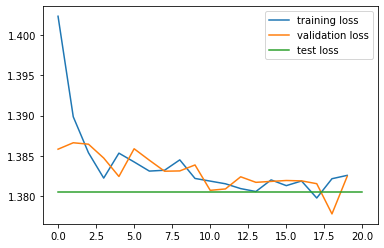

In [0]:
import matplotlib.pyplot as plt
plt.plot(results['train_loss'])
plt.plot(results['val_loss'])
plt.plot((0,20),(results['test_loss'],results['test_loss']))

plt.legend(['training loss', 'validation loss','test loss'])

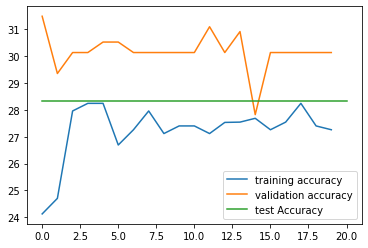

In [0]:
plt.plot(results['train_acc'])
plt.plot(results['val_acc'])
plt.plot((0,20),(results['test_acc'],results['test_acc']))
plt.legend(['training accuracy', 'validation accuracy','test Accuracy'])


In [0]:
def predict_category(text,Field_TEXT,Field_LABEL,classifier):
    preprocessed_sample = [Field_TEXT.preprocess(sample)]
    processed_sample = Field_TEXT.process(preprocessed_sample).to(args.device)
    y_pred = classifier(processed_sample)
    y_pred_np = y_pred.to(torch.device("cpu")).detach().numpy()

    return Field_LABEL.vocab.itos[np.argmax(y_pred_np)]


In [0]:
sample = "The merger did not work out"
predict_category(sample,Field_TEXT,Field_LABEL,classifier)

'politics'

In [0]:
sample = "India won by 7 wickets"
predict_category(sample,Field_TEXT,Field_LABEL,classifier)

'politics'

# *****************   End of NoteBook *****************